<a href="https://colab.research.google.com/github/Anfaga/TFM-BigData-DataScience-VIU/blob/main/KNN_Regression_Covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Carlos Andrés Falla Gaitán - TFM Máster en BigData y DataScience VIU


# KNN Covid-19

Aplicación de Técnicas de Aprendizaje Automático Supervisado para el Pronóstico del Número de Casos Nuevos de Covid19 en Bogotá-Colombia.

El propósito es estimar el número de casos nuevos de Coavid-19 en la ciudad de Bogotá, Colombia.

Se usará análisis de regresión con algoritmos KNN (CART) con el fin de explicar el número de casos con características seleccionadas de los sectores de Salud, Ambiente, Transporte, Seguridad y Finanzas.

## Carga de Datos

In [ ]:
# 0. load data from file
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving Base_Covid.csv to Base_Covid.csv
User uploaded file "Base_Covid.csv" with length 21125 bytes


In [ ]:
# 0. load data in DataFrame
import pandas as pd
import io
bcasos = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')), 
                    index_col = 'fecha_caso')
bcasos.head()

,Casos,Pruebas_PCR,Casos_Salud,RT,Ocupacion_Camas,Ocupacion_UCI,Ocupacion_Crematorios,Temp_Min,Temp_Max,Pasajeros_TM,Vuelos,Trafic,Hurtos,Lesiones_Personales,TRM,TIP
fecha_caso,,,,,,,,,,,,,,,,
2020-03-01,1,0,0,1.183851,0.0,0.0,11.5,10.00,21.17,402450,0,0.0,39,116,3539.86,4.25
2020-03-02,1,0,0,2.401324,0.0,0.0,9.0,9.17,21.60,935858,0,0.0,44,59,3539.86,4.25
2020-03-03,0,0,0,1.704885,0.0,0.0,8.0,9.30,22.11,1128778,0,0.0,71,57,3512.17,4.25
2020-03-04,5,0,0,1.862228,0.0,0.0,15.0,9.57,22.29,1103128,0,0.0,66,66,3455.56,4.25
2020-03-05,5,0,0,1.988661,0.0,0.0,12.5,6.23,23.37,1086023,0,0.0,71,61,3458.45,4.25


In [ ]:
bcasos.describe()

,Casos,Pruebas_PCR,Casos_Salud,RT,Ocupacion_Camas,Ocupacion_UCI,Ocupacion_Crematorios,Temp_Min,Temp_Max,Pasajeros_TM,Vuelos,Trafic,Hurtos,Lesiones_Personales,TRM,TIP
count,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,1.840000e+02,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000
mean,1289.548913,211461.076087,34.706522,1.183851,0.396958,0.477447,32.130435,8.315543,18.730707,9.106156e+05,45.141304,-63.025741,30.429348,38.744565,3808.858913,3.129076
std,1364.103548,260275.005703,32.808948,0.298155,0.356297,0.327466,23.317878,0.942078,1.424089,4.215432e+05,22.892517,26.250058,12.931742,19.474096,156.227097,0.701762
min,0.000000,0.000000,0.000000,0.683669,0.000000,0.000000,8.000000,6.000000,15.900000,2.147820e+05,0.000000,-96.995025,6.000000,6.000000,3455.560000,2.250000
25%,99.250000,0.000000,9.750000,0.994121,0.000000,0.260493,15.500000,7.600000,17.722500,6.068438e+05,34.750000,-85.905745,21.000000,26.000000,3716.755000,2.500000
50%,576.000000,102370.000000,22.000000,1.186114,0.438112,0.443203,20.750000,8.275000,18.580000,9.433445e+05,52.000000,-63.661356,30.000000,35.000000,3775.100000,3.000000
75%,2396.750000,352121.250000,57.500000,1.280807,0.757476,0.813328,47.275000,8.870000,19.617500,1.165678e+06,61.000000,-48.111818,39.000000,46.000000,3932.720000,3.750000
max,6862.000000,870408.000000,139.000000,2.401324,0.874180,0.931959,95.500000,11.600000,23.370000,3.020938e+06,85.000000,1.384968,71.000000,116.000000,4153.910000,4.250000


Seleccionamos las variables con las que trabajar. Paraesto vamos a utilizar los análisi hechos previamente.



## Análisis de Correlación

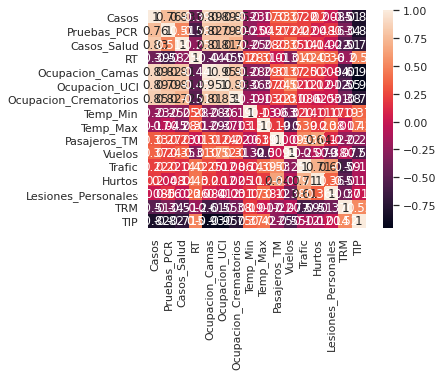

In [ ]:
import seaborn as sns

sns.set()
sns.heatmap(bcasos.corr(), square=True, annot=True)

## Modelado

### Partición del Conjunto de Datos: Training and Testing

Antes de proceder a crear los modelos para predecir vamos a dividir nuestro conjunto de datos en dos partes una para entrenamiento (tuning) y otra para test. Para ello vamos a utilizar los datos de marzo a julio 2019 para entrenamiento y agosto 2019 para pruebas.

In [ ]:
# 0.1 features and labels

df = bcasos[['Ocupacion_UCI','Temp_Min','Temp_Max','Pasajeros_TM','Vuelos','Trafic','Hurtos','TRM','Casos']]

train = df.loc['2020-03-01':'2020-07-31']
test  = df.loc['2020-08-01':]
test.head()


,Ocupacion_UCI,Temp_Min,Temp_Max,Pasajeros_TM,Vuelos,Trafic,Hurtos,TRM,Casos
fecha_caso,,,,,,,,,
2020-08-01,0.899117,7.7,21.55,911087,56,-60.630662,37,3733.08,2918
2020-08-02,0.880299,6.4,19.00,1593890,43,-82.611085,21,3733.08,2215
2020-08-03,0.887936,6.9,18.60,1155295,34,-67.698807,31,3733.08,3385
2020-08-04,0.892042,8.4,18.76,1178727,60,-69.572756,37,3768.39,3489
2020-08-05,0.892966,8.4,17.70,1176167,61,-66.000603,34,3792.98,3964


### Parametrización

Se seleccionanlos parámetros KNeighbors, k y pesos, y como criterio de evaluavión se va a utilizar MAE.

In [ ]:
# reseteamos el index con el fin de evitar problemas en la validación cruzada
train.reset_index(drop = True, inplace = True)
train.head()

,Ocupacion_UCI,Temp_Min,Temp_Max,Pasajeros_TM,Vuelos,Trafic,Hurtos,TRM,Casos
0,0.0,10.00,21.17,402450,0,0.0,39,3539.86,1
1,0.0,9.17,21.60,935858,0,0.0,44,3539.86,1
2,0.0,9.30,22.11,1128778,0,0.0,71,3512.17,0
3,0.0,9.57,22.29,1103128,0,0.0,66,3455.56,5
4,0.0,6.23,23.37,1086023,0,0.0,71,3458.45,5


Min Value uniform : 906.1481862745095 (17)
Min Value distance : 940.9694949854945 (48)


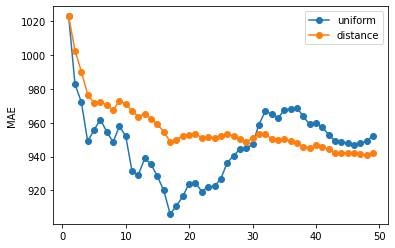

In [ ]:
from sklearn import neighbors
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np

cv = KFold(n_splits = 10, shuffle = False) #
# se podría utilizar https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html 


for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []
   for n_neighbors in range(1,50):
       fold_accuracy = []
       knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
       # verificar cada uno de los modelos con validación cruzada.
       for train_fold, test_fold in cv.split(train):
          # División train test aleatoria
          f_train = train.loc[train_fold]
          f_test = train.loc[test_fold]
          # entrenamiento y ejecución del modelo
          knn.fit( X = f_train.drop(['Casos'], axis=1), 
                               y = f_train['Casos'])
          y_pred = knn.predict(X = f_test.drop(['Casos'], axis = 1))
          # evaluación del modelo
          mae = mean_absolute_error(f_test['Casos'], y_pred)
          fold_accuracy.append(mae)
       total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
   
   plt.plot(range(1,len(total_scores)+1), total_scores, 
             marker='o', label=weights)
   print ('Min Value ' +  weights + " : " +  str(min(total_scores)) +" (" + str(np.argmin(total_scores) + 1) + ")")
   plt.ylabel('MAE')      
    
plt.legend()
plt.axis('tight')
plt.legend()


plt.show() 



### Construcción y ejecución del modelo 



Una vez que hemos identificado la mejor parametrización vamos a pasar a hacer una ejecución del modelo y vamos graficar sus resultados.

In [ ]:
# constructor
n_neighbors = 7
weights = 'uniform'
knn = neighbors.KNeighborsRegressor(n_neighbors= n_neighbors, weights=weights) 
# fit and predict

knn.fit( X = train.drop(['Casos'], axis=1), y = train['Casos'])
y_pred = knn.predict(X = test.drop(['Casos'], axis = 1))
mae = mean_absolute_error(test['Casos'], y_pred)
print ('MAE', mae)



MAE 902.8690702087287


Guardamos los resultados.

In [ ]:
# round the result and cast to int
import numpy as np
res = np.rint(y_pred) # round
res = res.astype(int) # cast to int
# generate output
output = pd.DataFrame({ 'date': test.index, 'result': res})


from google.colab import files

with open('result_knn0.csv', 'w') as f:
  output.to_csv(f,  index = False)
  

files.download('result_knn0.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Visualizamos la predicción con la realidad.

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


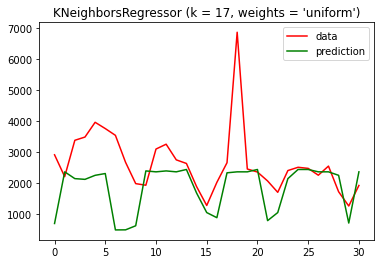

In [ ]:

from sklearn.metrics import mean_absolute_error

                    
# x axis for plotting
import numpy as np
xx = np.stack(i for i in range(test['Casos'].shape[0]))
plt.plot(xx, test['Casos'], c='r', label='data')
#plt.plot(xx, y, c='k', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors,
                                                                weights))

plt.show()